[article, ici](https://arxiv.org/pdf/2103.04318.pdf)

[github, ici](https://github.com/aimat-lab/gcnn_keras)



In [1]:
pip install kgcnn

     |████████████████████████████████| 92kB 3.7MB/s 


In [2]:
import time

# mpl.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

from kgcnn.data.mutagen.mutag import mutag_graph
from kgcnn.literature.Unet import make_unet as make_unet
from kgcnn.utils.adj import add_self_loops_to_edge_indices
from kgcnn.utils.data import ragged_tensor_from_nested_numpy
from kgcnn.utils.learning import lr_lin_reduction

Keras utils: Register custom activation:  {'leaky_softplus': <function leaky_softplus at 0x7f90e01b07a0>, 'shifted_softplus': <function shifted_softplus at 0x7f90e01b0440>, 'softplus2': <function softplus2 at 0x7f90e01b03b0>}


Setup local data folder for kgcnn at:  /root/.kgcnn
Database path: /root/.kgcnn/data/mutagen
Read Zip File ... done
Extracting Zip folder...done
Making graph ...Datainfo: Mol index which has unconnected [] with [] in total 0
done
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
node_input (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
node_embedding (Embedding)      (None, None, 128)    7680        node_input[0][0]                 
__________________________________________________________________________________________________
dense_ragged (DenseRagged)      (None, None, 128)    16512       node_embedding[0][0]             
______________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/pooling_local_edges_7/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/pooling_local_edges_7/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/model/pooling_local_edges_7/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/gather_nodes_outgoing_7/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/model/gather_nodes_outgoing_7/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/model/gather_n

6/6 - 12s - loss: 0.6929 - accuracy: 0.5266
Epoch 2/500
6/6 - 5s - loss: 0.6872 - accuracy: 0.6686 - val_loss: 0.6855 - val_accuracy: 0.6316
Epoch 3/500
6/6 - 0s - loss: 0.6820 - accuracy: 0.6686
Epoch 4/500
6/6 - 1s - loss: 0.6775 - accuracy: 0.6686 - val_loss: 0.6775 - val_accuracy: 0.6316
Epoch 5/500
6/6 - 0s - loss: 0.6730 - accuracy: 0.6686
Epoch 6/500
6/6 - 1s - loss: 0.6681 - accuracy: 0.6686 - val_loss: 0.6698 - val_accuracy: 0.6316
Epoch 7/500
6/6 - 0s - loss: 0.6636 - accuracy: 0.6686
Epoch 8/500
6/6 - 1s - loss: 0.6576 - accuracy: 0.6686 - val_loss: 0.6617 - val_accuracy: 0.6316
Epoch 9/500
6/6 - 0s - loss: 0.6533 - accuracy: 0.6686
Epoch 10/500
6/6 - 1s - loss: 0.6474 - accuracy: 0.6686 - val_loss: 0.6540 - val_accuracy: 0.6316
Epoch 11/500
6/6 - 0s - loss: 0.6433 - accuracy: 0.6686
Epoch 12/500
6/6 - 1s - loss: 0.6384 - accuracy: 0.6686 - val_loss: 0.6486 - val_accuracy: 0.6316
Epoch 13/500
6/6 - 1s - loss: 0.6350 - accuracy: 0.6686
Epoch 14/500
6/6 - 1s - loss: 0.6316 - a

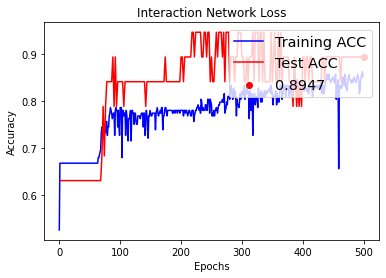

In [3]:
# Download and prepare dataset
labels, nodes, edge_indices, edges = mutag_graph()
labels[labels < 0] = 0
labels = np.expand_dims(labels, axis=-1)
graph_state = np.array([len(x) for x in nodes])
edge_indices = [add_self_loops_to_edge_indices(x) for x in edge_indices]
edges = [np.ones_like(x, dtype=np.float)[:, 0:1] for x in edge_indices]

# Train Test split
labels_train, labels_test, nodes_train, nodes_test, edges_train, edges_test, edge_indices_train, edge_indices_test, graph_state_train, graph_state_test = train_test_split(
    labels, nodes, edges, edge_indices, graph_state, test_size=0.10, random_state=42)
del labels, nodes, edges, edge_indices, graph_state  # Free memory after split, if possible

# Convert to tf.RaggedTensor or tf.tensor
# a copy of the data is generated by ragged_tensor_from_nested_numpy()
nodes_train, edges_train, edge_indices_train, graph_state_train = ragged_tensor_from_nested_numpy(
    nodes_train), ragged_tensor_from_nested_numpy(edges_train), ragged_tensor_from_nested_numpy(
    edge_indices_train), tf.constant(graph_state_train)

nodes_test, edges_test, edge_indices_test, graph_state_test = ragged_tensor_from_nested_numpy(
    nodes_test), ragged_tensor_from_nested_numpy(edges_test), ragged_tensor_from_nested_numpy(
    edge_indices_test), tf.constant(graph_state_test)

# Define input and output data
xtrain = nodes_train, edges_train, edge_indices_train
xtest = nodes_test, edges_test, edge_indices_test
ytrain = labels_train
ytest = labels_test

model = make_unet(
    input_node_shape=[None],
    input_edge_shape=[None, 1],
    input_embedd={"input_node_vocab": 60,
                  "input_node_embedd": 128},
    # Output
    output_embedd={"output_mode": 'graph', "output_type": 'padded'},
    output_mlp={"use_bias": [True, False], "units": [25, 1],
                "activation": ['relu', 'sigmoid'],
                },
    # Model specific
    hidden_dim=128,
    depth=4,
    k=0.3,
    score_initializer='ones',
    use_bias=True,
    activation='relu',
    is_sorted=False,
    has_unconnected=True,
    use_reconnect=True
)

# Define learning rate
learning_rate_start = 1e-4
learning_rate_stop = 1e-5
epo = 500
epomin = 400
epostep = 2

# Compile model with optimizer
optimizer = tf.keras.optimizers.Adam(lr=learning_rate_start)
cbks = tf.keras.callbacks.LearningRateScheduler(lr_lin_reduction(learning_rate_start, learning_rate_stop, epomin, epo))
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
print(model.summary())

start = time.process_time()
hist = model.fit(xtrain, ytrain,
                 epochs=epo,
                 batch_size=32,
                 callbacks=[cbks],
                 validation_freq=epostep,
                 validation_data=(xtest, ytest),
                 verbose=2
                 )
stop = time.process_time()
print("Print Time for taining: ", stop - start)

trainlossall = np.array(hist.history['accuracy'])
testlossall = np.array(hist.history['val_accuracy'])

mae_valid = testlossall[-1]

# Plot loss vs epochs
plt.figure()
plt.plot(np.arange(trainlossall.shape[0]), trainlossall, label='Training ACC', c='blue')
plt.plot(np.arange(epostep, epo + epostep, epostep), testlossall, label='Test ACC', c='red')
plt.scatter([trainlossall.shape[0]], [mae_valid], label="{0:0.4f} ".format(mae_valid), c='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Interaction Network Loss')
plt.legend(loc='upper right', fontsize='x-large')
plt.savefig('unet_loss.png')
plt.show()